In [185]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as npy
from scipy import stats
sns.set_style('dark')

First, let's start with figuring out the best way to value offensive performance. There's a lot of analysis online for explaining this, but they're often complicated explanations. This is mostly showing which offensive stats are the most valuable. We're going to do this by taking all the data for all the teams in the live ball era (1920-2017) and seeing how well certain stats correlate with runs scored by that team. Using runs scored may be oversimplifying value, as it doesn't account for luck or for park factors, but with so much data it'll do the job for these purposes.

In [186]:
def Correlation(Dataset,Statistic, X, Y):
    Slope, Intercept = np.polyfit(Dataset[Statistic], Dataset['R'],1)

    R = stats.pearsonr(Dataset[Statistic],Dataset['R'])[0]
    R = round(R,3)
    
    plt.scatter(Dataset[Statistic], Dataset['R'],alpha=.2)
    plt.plot(Dataset[Statistic], Slope*Dataset[Statistic] + Intercept)
    plt.xlabel(Statistic)
    plt.ylabel('Runs')
    plt.text(x = X, y = Y, s = f'Correlation of {R}', weight = 'bold')
    plt.show()
AllTeams = pd.read_csv('TeamStatsLiveBallEra.csv')
AllTeams = AllTeams[AllTeams['Season'] != 1981]
AllTeams = AllTeams[AllTeams['Season'] != 1994]
AllTeams.index = AllTeams.index + 1

# Batting Average

If you've talked to any baseball stat nerd and mentioned batting average, they most likely were somewhat condescending towards that. This is a little unfair! Okay, yes (Spoiler Alert), batting average is not as important as people make it seem, but how would the average baseball fan know that! The batting average has been the most popular baseball stat, since the beginning of the game. The average fan should not be expected to realize it's not super meaningful right off the bat. So, let's prove that.

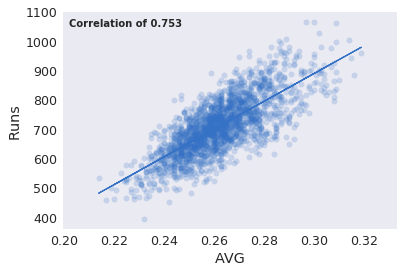

In [187]:
Correlation(AllTeams,'AVG',.202,1050)

A Pearson correlation coefficient is scaled from -1 to 1. 1 being perfect positively, and -1 being perfect negatively. Team Batting average has a correlation of 0.753 with Team Runs. Not bad! But we can do better...

# On-Base Percentage

Have you seen or read Moneyball? Well, you definitely should! The author and Billy Beane explains a lot of concepts better than I ever could. One of the main points in the book, and in Beane's front office, is the importance of walks. 

What's the difference between a single and a walk in terms of getting on base? Nothing! So the first step we can take is account for how likely a player gets on base by any means necessary. This is called On-Base Percentage. 

$OBP = \frac{Hits*Walks}{PA}$

Let's see how that compares to Team Runs

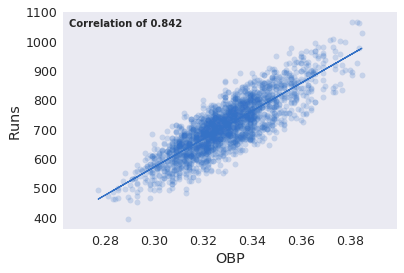

In [188]:
Correlation(AllTeams,'OBP',.265,1050)

Better! Both visually and numerically (with a higher correlation coefficient) more accurate, it seems our logic for getting on base checks out.

But still, we can think of flaws in this. OBP treats all hits and walks equal, but that's not true! Everyone would gladly pick the home-run over the single, and for good reason. So we need a metric to measure the quantity, but also the quality, of the players hits. With that, let's look at Slugging Percentage

# Slugging Percentage

Slugging percentage attempts to account for the quality of one's hits and walks. It's similar to OBP, but weights the hits by the number of bags they gave the hitter. By this logic, a home run is 4x more valuable than a single, a triple is 3x more valuable, and so on. 

$ \mathrm{SLG} = \frac{(\mathit{1B}) + (2 \times \mathit{2B}) + (3 \times \mathit{3B}) + (4 \times \mathit{HR})}{AB}$

Let's see how SLG does!

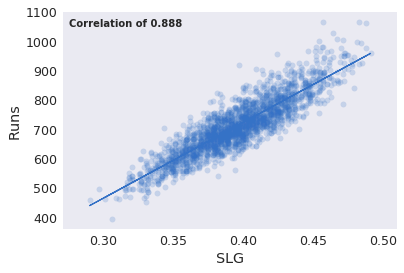

In [189]:
Correlation(AllTeams,'SLG',.275,1050)

So slugging percentage seems to be a tad bit better than Slugging percentage, but not by much. It's important to note that Slugging percentage does not account for walks. We can improve it. 

# OPS

So we have two metrics, OBP and SLG, that both address logical parts of run value, but each with different flaws. So what if we combined them? We would then be accounting for the quantity of total bases (including walks), along with accounting for the quality in a nice clean calculation. So let's look.

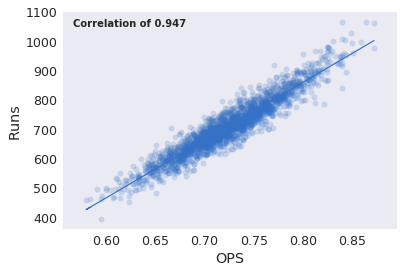

In [190]:
AllTeams['OPS'] = AllTeams.OBP + AllTeams.SLG
Correlation(AllTeams,'OPS',.567,1050)

This is getting really close! The biggest improvement in these upgrades since we ditched batting average, obviously there's something to be said for accounting for both metrics. Can we do better though?

If you think about it, it's a big assumption to say that OBP and SLG should be weighted equally in the OPS calculation. Since OBPs are smaller than SLG, that equal weight actually makes OBP much less important in the calculation then it should be. This makes sense if we think of some extreme examples. OPS would undervalue a player like Ichiro Suzuki, as his high OBP is offset by a larger drop in SLG due to his slap-hitting style. Ichiro-caliber players are really valuable! So how do we remedy this?

So, through trial and error, people have determined that OBP is roughly 1.75x more valuable than Slugging percentage. I could prove this to you, but that involves math... or I could just show you the results that prove it. Let's do that:

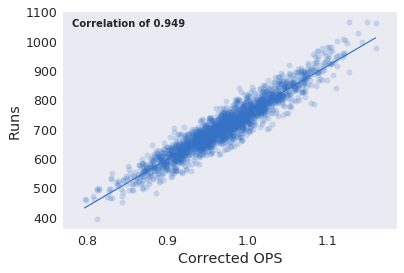

In [191]:
AllTeams['Corrected OPS'] = AllTeams.OBP*1.75 + AllTeams.SLG
Correlation(AllTeams,'Corrected OPS',.78,1050)

After increasing the weight of OBP, the correlation marginally increases. It's getting harder and harder to improve, as we're already pretty close to perfect, but it's an improvement nonetheless. Is there anything left? Yes, yes there is.

# wOBA

weighted OBA, or wOBA, looks more similar to SLG than OBP. 

$wOBA = (0.692×uBB + 0.723×HBP + 0.884×1B + 1.256×2B + 1.591×3B +
2.050×HR) / (AB + BB – IBB + SF + HBP)$

Remember how  SLG didn't account for walks? while wOBA does. The other change is the amount of weight extra base hits get. wOBA cuts down that weight considerably, which makes sense if we think of this thought exercise:

SCENARIO 1
Player 1 at bat: hits a homerun
Total SLG: 4.000

SCENARIO 2
Player 1 at bat: singles
Player 2 at bat: singles, Player 1 to 2nd
Player 3 at bat: singles, Player 1 to 3rd, Player 2 to 2nd
Player 4 at bat: singles, Player 1 scores, Player 2 to 3rd, Player 3 to 2nd
Total SLG: 1.000 + 1.000 + 1.000 + 1.000 = 4.000
AVG SLG: 1.000

Scenario 2 leaves the bases loaded with no outs, while Scenario 1 leaves them empty. Scenario 2 is much more preferable for scoring runs, while being equal, or even worse, depending on whose slugging percentage you look at. By running models solving for those parameters, wOBA attempts to value extra base hits correctly. wOBA has different ratios for each season, so let's look at just one season:


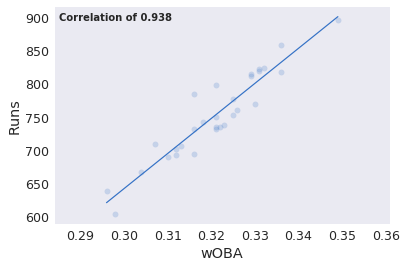

In [192]:
Teams2017 = AllTeams[AllTeams['Season'] == 2017]
Correlation(Teams2017,'wOBA',.285,895)

So, it's about the same! Not quite as dramatic as maybe some (and I) were hoping for, but that's to be expected with only 30 data points.

The point of this exercise is not to say wOBA is good, the rest is bad. Hopefully you were able to see that each metric does a pretty good job, but some do better than others.